In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 課題1

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [0]:
def ReLU(x):
    return np.maximum(0, x)

# ReLU(np.array([1,-1,3]))
# array([1, 0, 3])

特徴ベクトル $ \boldsymbol{x}_{v}^{(t)} \in \mathbb{R}^D $,  
特徴行列 $ F^{(t)} = \{\boldsymbol{x}_{v}^{(t)}\}_{v \in V} \in \mathbb{R}^{D \times |V|} $

(集約1): $ \boldsymbol{a}_{v}^{(t)} = \sum_{w:(w, v) \in E} \boldsymbol{x}_{w}^{(t)} $  
(集約2): $ \boldsymbol{x}_{v}^{t+1} = f(W \cdot \boldsymbol{a}_{v}^{(t)}) $

In [0]:
class Graph:
    def __init__(self, A_input):
        self.A = A_input  # 隣接行列
        self.V = self.A.shape[0]  # 頂点数
        self.T = 2  # 集約回数

    # 集約関数
    def Aggregate(self, W):
        D = W.shape[0]  # パラメータの次元
        F = np.zeros((D, self.V))  # D☓Vのゼロ行列(特徴行列)
        F[0] = 1  # 各頂点の特徴ベクトルの最初の要素を1に初期化

        for i in range(self.T):
            a = F @ self.A
            F = ReLU(W @ a)

        return F @ np.ones((self.V, 1))

In [0]:
A = np.array([[0, 1, 0, 0],
              [1, 0, 1, 1],
              [0, 1, 0, 1],
              [0, 1, 1, 0]])
G = Graph(A)
W1 = np.ones((8, 8))
W2 = np.triu(np.ones((8, 8)))
Vec1 = G.Aggregate(W1)
Vec2 = G.Aggregate(W2)
F0 = np.zeros((8, 4))
F0[0] = 1

print("test")
print(Vec1)
print(Vec2)

test
[[144.]
 [144.]
 [144.]
 [144.]
 [144.]
 [144.]
 [144.]
 [144.]]
[[18.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


# 課題2

問題概要：グラフを入力した場合にそのグラフのラベルを予測する。  
e.g.)化学構造を入力したら、有毒か否かを判定する。

$ A \in \mathbb{R}^D $  
$ b \in \mathbb{R} $  
$ \theta = \{ W, A, b \} :$ 分類器のパラメータ集合  
$ s = A \cdot {\boldsymbol h}_G + b $  
$ p = {\rm Sigmoid}(s) = 1 / (1 + \exp(-s)) $  
$ L = L(G, y, ; \theta) = -y\log{p} - (1-y)\log{(1-p)} $: グラフ$G$に対する正解ラベルを$y \in \{0, 1\}$とするとき、予測に対するbinary cross-entropy損失関数


In [0]:
# sigmoid関数
def sigmoid(s):
    return 1 / (1 + np.exp(-s))

In [0]:
# cross-entropy損失関数
# オーバーフロー対策
def binary_cross_entropy(s, y):
    if s >= 35:
        return y * np.log(1 + np.exp(-s)) + (1 - y) * s
    elif s <= -35: 
        return y * (-s) + (1 - y) * np.log(1 + np.exp(s))
    else:
        return y * np.log(1 + np.exp(-s)) + (1 - y) * np.log(1 + np.exp(s))

In [0]:
# 分類器
class Classifier:
    def __init__(self, _D=8, _alpha=0.0001, _epsilon=0.001, _B=8, _eta=0.9):
        self.D = _D  # Wの次元数
        self.alpha = _alpha  # 学習率
        self.epsilon = _epsilon  # 微分摂動
        self.B = _B  # batch size
        self.eta = _eta  # moment

        # パラメータの初期値
        self.W = np.random.normal(0, 0.4, (self.D, self.D))
        self.A = np.random.normal(0, 0.4, (self.D, 1))
        self.b = 0

        # SGD, MSGDで用いる、前スッテプの更新量の初期化
        self.w_W = np.zeros((self.D, self.D))
        self.w_A = np.zeros((self.D, 1))
        self.w_b = 0.0

    # 損失計算
    def calculation_loss(self, G, y):
        h_G = G.Aggregate(self.W)
        s = self.A.T @ h_G + self.b
        return binary_cross_entropy(s, y)

    # グラフ集合G, ラベルデータ集合yに対する損失関数と精度の平均
    def calculation_loss_and_accuracy(self, G, y):
        loss = []
        accuracy = []
        for i in range(len(G)):
            h_G = G[i].Aggregate(self.W)
            s = self.A.T @ h_G + self.b
            predict = int(sigmoid(s) > 0.5)  # 01
            loss.append(binary_cross_entropy(s, y[i]))
            accuracy.append(int(y[i] == predict))
        return np.mean(np.array(loss)), np.mean(np.array(accuracy))

    # 勾配計算
    def calculation_grad(self, G, y):
        grad_W = np.zeros((self.D, self.D))
        grad_A = np.zeros((self.D, 1))
        grad_b = 0

        now_loss = self.calculation_loss(G, y)

        for i in range(self.D):
            for j in range(self.D):
                self.W[i][j] += self.epsilon
                grad_W[i][j] = (self.calculation_loss(G, y) - now_loss) / self.epsilon
                self.W[i][j] -= self.epsilon

        for i in range(self.D):
            self.A[i] += self.epsilon
            grad_A[i] = (self.calculation_loss(G, y) - now_loss) / self.epsilon
            self.A[i] -= self.epsilon

        self.b += self.epsilon
        grad_b = (self.calculation_loss(G, y) - now_loss) / self.epsilon
        self.b -= self.epsilon

        return grad_W, grad_A, grad_b

    # Stochastic Gradient Descent(SGD)に基づき、パラメータを更新するメソッド
    def Stochastic_Gradient_Descent(self, train_G, train_y):
        Data_num = len(train_G)  # 訓練データ数
        shuffle_index = list(range(Data_num))  # 1エポックにおいてサンプリングする順番を示すリストを作成
        np.random.shuffle(shuffle_index)  # 先述のリストをシャッフル

        # 1エポックの学習を行う(B個のミニバッチに対し勾配の計算を行っていく)
        for start in range(0, Data_num, self.B):
            # 勾配を格納するためのリスト
            grad_W = []
            grad_A = []
            grad_b = []

            # ミニバッチ内(shuffle_index内の[start:start + self.B + 1]の要素に対し、勾配を計算
            for i in range(start, min(start + self.B, Data_num)):
                Gi_grad_W, Gi_grad_A, Gi_grad_b = self.calculation_grad(train_G[shuffle_index[i]], train_y[shuffle_index[i]])
                grad_W.append(Gi_grad_W)
                grad_A.append(Gi_grad_A)
                grad_b.append(Gi_grad_b)

            # 計算した勾配の平均をとる
            del_theta_W = np.mean(grad_W, axis = 0)
            del_theta_A = np.mean(grad_A, axis = 0)
            del_theta_b = np.mean(np.array(grad_b))

            # 勾配の平均をもとにパラメータを更新
            self.W = self.W - self.alpha * del_theta_W
            self.A = self.A - self.alpha * del_theta_A
            self.b = self.b - self.alpha * del_theta_b

    # Momentum SGDに基づき、パラメータを更新するメソッド(Stochastic Gradient Descentと同じ部分はコメントを省略しています)
    def Momentum_SGD(self, train_G, train_y):
        Data_num = len(train_G)
        shuffle_index = list(range(Data_num))
        np.random.shuffle(shuffle_index)
        
        for start in range(0, Data_num, self.B):
            grad_W = []
            grad_A = []
            grad_b = []
            
            for i in range(start, min(start + self.B + 1, Data_num)):
                Gi_grad_W, Gi_grad_A, Gi_grad_b = self.calculation_grad(train_G[shuffle_index[i]], train_y[shuffle_index[i]])
                grad_W.append(Gi_grad_W)
                grad_A.append(Gi_grad_A)
                grad_b.append(Gi_grad_b)
            
        del_theta_W = np.mean(grad_W, axis = 0)
        del_theta_A = np.mean(grad_A, axis = 0)
        del_theta_b = np.mean(np.array(grad_b))

        # 勾配の平均と、前のステップにおける更新量に基づきパラメータを更新
        self.W = self.W - self.alpha * del_theta_W + self.eta * self.w_W
        self.A = self.A - self.alpha * del_theta_A + self.eta * self.w_A
        self.b = self.b - self.alpha * del_theta_b + self.eta * self.w_b

        # 前のステップにおける更新量を更新
        self.w_W = -self.alpha * del_theta_W + self.eta * self.w_W
        self.w_A = -self.alpha * del_theta_A + self.eta * self.w_A
        self.w_b = -self.alpha * del_theta_b + self.eta * self.w_b

label 0
A
 [[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 1 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]



h_G
 [[ 7.81840742]
 [ 7.98107319]
 [ 0.        ]
 [ 0.        ]
 [ 0.50645443]
 [ 4.10886735]
 [12.32907726]
 [ 0.        ]]
label 1
A
 [[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 1 1 0 0 0]
 [1 1 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0]]



h_G
 [[ 0.        ]
 [52.68836547]
 [ 0.        ]
 [ 0.39866369]
 [41.39146663]
 [ 0.        ]
 [25.06864016]
 [13.95485975]]


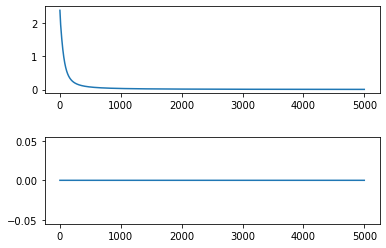

In [0]:
path = "/content/drive/My Drive/study/GNN/scratch/datasets/train/"
data_ids = ["21", "55"]  # 今回使うグラフデータ

plt.subplots_adjust(wspace=0.5, hspace=0.5)

for pos, data_id in enumerate(data_ids):
    graph_name = path + data_id + "_graph.txt"
    label_name = path + data_id + "_label.txt"

    # グラフ読み込み
    with open(graph_name, "r") as f:
        A = [l.strip().split(" ") for l in f.readlines()][1:]
        A = [*map(lambda l: [int(n) for n in l], A)]

    # ラベル読み込み
    with open(label_name, "r") as f:
        label = int(f.readlines()[0].strip())

    A = np.array(A)
    G = Graph(A)

    print("label", label)
    print("A\n", A)

    clf = Classifier()

    loss = clf.calculation_loss(G, label)

    # 損失を保存
    loss_data = [loss]

    for i in tqdm(range(0, 5000)):
        grad_W, grad_A, grad_b = clf.calculation_grad(G, label)
        clf.W = clf.W - clf.alpha * grad_W
        clf.A = clf.A - clf.alpha * grad_A
        clf.b = clf.b - clf.alpha * grad_b

        loss_data.append(float(clf.calculation_loss(G, label)))

    print("h_G\n", G.Aggregate(clf.W))

    plt.subplot(2, 1, pos+1)
    plt.plot(list(range(0, len(loss_data))), loss_data)

plt.show()

# 課題3

In [0]:
path = "/content/drive/My Drive/study/GNN/scratch/datasets/train/"
graphs = []
labels = []

# データの読み込み
for i in tqdm(range(2000)):
    graph_name = path + str(i) + "_graph.txt"
    label_name = path + str(i) + "_label.txt"

    # グラフ読み込み
    with open(graph_name, "r") as f:
        A = [l.strip().split(" ") for l in f.readlines()][1:]
        A = [*map(lambda l: [int(n) for n in l], A)]

    # ラベル読み込み
    with open(label_name, "r") as f:
        label = int(f.readlines()[0].strip())

    A = np.array(A)
    G = Graph(A)

    graphs.append(G)
    labels.append(label)

print("label", label)
print("A\n", A)


label 0
A


In [0]:
# 学習用データと検定用データに分割
train_G = graphs[:int(len(graphs) / 2)]
train_y = labels[:int(len(labels) / 2)]
test_G = graphs[int(len(graphs) / 2):]
test_y = labels[int(len(labels) / 2):]

In [0]:
BATCH_SIZE = 32
EPOCH = 100

In [0]:
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']  # 色のリスト



# 分類器を用意
clf_SGD = Classifier(_B = BATCH_SIZE)
clf_MSGD = Classifier(_B = BATCH_SIZE)

train_loss_SGD, train_acc_SGD = clf_SGD.calculation_loss_and_accuracy(train_G, train_y)
test_loss_SGD, test_acc_SGD = clf_SGD.calculation_loss_and_accuracy(test_G, test_y)

# 計算した平均損失と平均精度を格納するリストを定義
train_loss_SGDs = [train_loss_SGD]
train_acc_SGDs = [train_acc_SGD]
test_loss_SGDs = [test_loss_SGD]
test_acc_SGDs = [test_acc_SGD]

train_loss_MSGD, train_acc_MSGD = clf_MSGD.calculation_loss_and_accuracy(train_G, train_y)
test_loss_MSGD, test_acc_MSGD = clf_MSGD.calculation_loss_and_accuracy(test_G, test_y)

# 計算した平均損失と平均精度を格納するリストを定義
train_loss_MSGDs = [train_loss_MSGD]
train_acc_MSGDs = [train_acc_MSGD]
test_loss_MSGDs = [test_loss_MSGD]
test_acc_MSGDs = [test_acc_MSGD]

for ep in tqdm(range(1, EPOCH+1)):
    clf_SGD.Stochastic_Gradient_Descent(train_G, train_y)
    clf_MSGD.Momentum_SGD(train_G, train_y)

    train_loss_SGD, train_acc_SGD = clf_SGD.calculation_loss_and_accuracy(train_G, train_y)
    test_loss_SGD, test_acc_SGD = clf_SGD.calculation_loss_and_accuracy(test_G, test_y)

    train_loss_SGDs.append(train_loss_SGD)
    train_acc_SGDs.append(train_acc_SGD)
    test_loss_SGDs.append(test_loss_SGD)
    test_acc_SGDs.append(test_acc_SGD)

    train_loss_MSGD, train_acc_MSGD = clf_MSGD.calculation_loss_and_accuracy(train_G, train_y)
    test_loss_MSGD, test_acc_MSGD = clf_MSGD.calculation_loss_and_accuracy(test_G, test_y)

    train_loss_MSGDs.append(train_loss_MSGD)
    train_acc_MSGDs.append(train_acc_MSGD)
    test_loss_MSGDs.append(test_loss_MSGD)
    test_acc_MSGDs.append(test_acc_MSGD)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


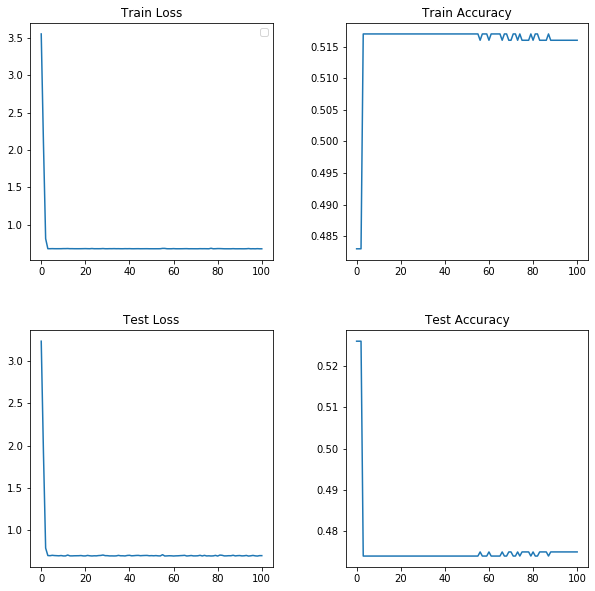

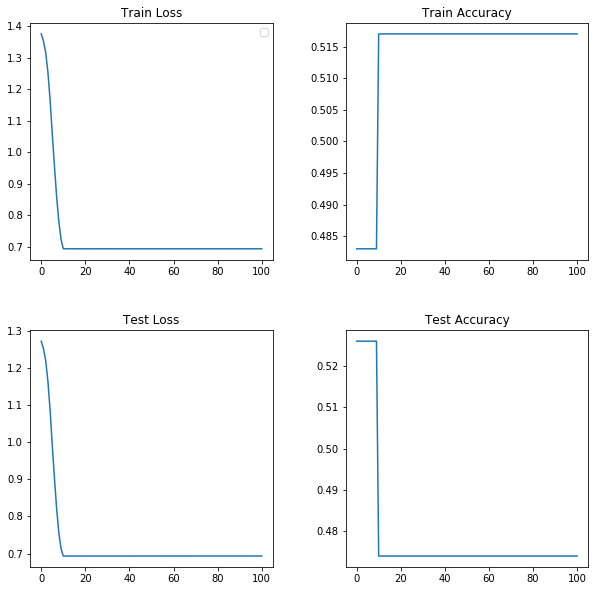

In [0]:
fig_SGD, ax_SGD = plt.subplots(2, 2, figsize = (10, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

fig_MSGD, ax_MSGD = plt.subplots(2, 2, figsize = (10, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

# SGDを用いる分類器に関して、得られた平均損失と平均精度のデータをプロットする
ax_SGD[0,0].plot(np.array(range(len(train_loss_SGDs))), train_loss_SGDs)
ax_SGD[0,1].plot(np.array(range(len(train_acc_SGDs))), train_acc_SGDs)
ax_SGD[1,0].plot(np.array(range(len(test_loss_SGDs))), test_loss_SGDs)
ax_SGD[1,1].plot(np.array(range(len(test_acc_SGDs))), test_acc_SGDs)

# Momentum SGDを用いる分類器に関して同様のことを行う
ax_MSGD[0,0].plot(np.array(range(len(train_loss_MSGDs))), train_loss_MSGDs)
ax_MSGD[0,1].plot(np.array(range(len(train_acc_MSGDs))), train_acc_MSGDs)
ax_MSGD[1,0].plot(np.array(range(len(test_loss_MSGDs))), test_loss_MSGDs)
ax_MSGD[1,1].plot(np.array(range(len(test_acc_MSGDs))), test_acc_MSGDs)

# グラフのタイトル・凡例を設定
ax_SGD[0,0].set_title("Train Loss")
ax_SGD[0,1].set_title("Train Accuracy")
ax_SGD[1,0].set_title("Test Loss")
ax_SGD[1,1].set_title("Test Accuracy")

ax_MSGD[0,0].set_title("Train Loss")
ax_MSGD[0,1].set_title("Train Accuracy")
ax_MSGD[1,0].set_title("Test Loss")
ax_MSGD[1,1].set_title("Test Accuracy")

In [0]:
A = [[0,0,0],
     [0,0,1],
     [1,1,0]]
A = np.array(A)
A = Graph(A)

h_G = A.Aggregate(clf_SGD.W)
s = clf_SGD.A.T @ h_G + clf_SGD.b
print("Predict", int(sigmoid(s) > 0.5))

Predict 1


In [0]:
A = [[0,0,0],
     [0,0,1],
     [1,0,0]]
A = np.array(A)
A = Graph(A)

h_G = A.Aggregate(clf_SGD.W)
s = clf_SGD.A.T @ h_G + clf_SGD.b
print("Predict", int(sigmoid(s) > 0.5))

Predict 0
